# Comparing uncertainty

Notebook compares the uncertainty estimates of RegVelo and VeloVI.

## Library imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.core import SIGNIFICANCE_PALETTE
from rgv_tools.plotting._significance import get_significance

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "hematopoiesis"

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

FIGURE_FORMATE = "svg"

In [4]:
terminal_states = ["Meg", "Mon", "Bas", "Ery", "Neu"]

## Data loading

In [5]:
uncertainty_rgv = pd.read_csv(DATA_DIR / DATASET / "results" / "uncertainty_rgv.csv")
uncertainty_vi = pd.read_csv(DATA_DIR / DATASET / "results" / "uncertainty_vi.csv")

In [6]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

## Define terminal states

In [7]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=6, cluster_key="cell_type", n_cells=10)
estimator.set_terminal_states(terminal_states, n_cells=10)

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

GPCCA[kernel=(0.8 * VelocityKernel[n=1947] + 0.2 * ConnectivityKernel[n=1947]), initial_states=None, terminal_states=['Bas', 'Ery', 'Meg', 'Mon', 'Neu']]

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


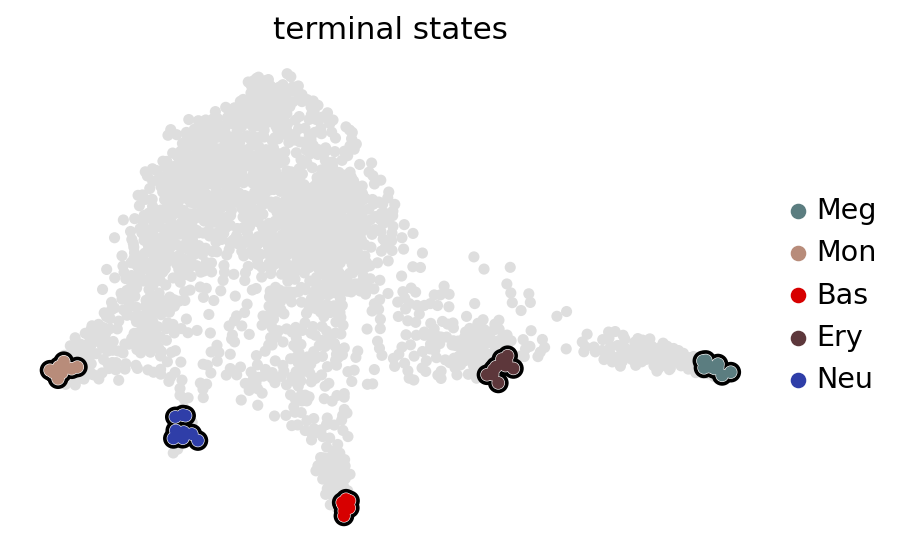

In [8]:
estimator.plot_macrostates(which="terminal", basis="draw_graph_fa", legend_loc="right", s=100)

In [9]:
uncertainty_rgv["terminal_state"] = estimator._term_states[0].tolist()

## Compare the ratio of each terminal state's uncertainty score to the mean value of the progenitor cells

In [10]:
regvi_score = uncertainty_rgv["uncertainty"].values / np.mean(
    uncertainty_rgv["uncertainty"].values[adata.obs["cell_type"].isin(["MEP-like", "GMP-like"])]
)
vi_score = uncertainty_vi["uncertainty"].values / np.mean(
    uncertainty_vi["uncertainty"].values[adata.obs["cell_type"].isin(["MEP-like", "GMP-like"])]
)

In [11]:
terminal_state = uncertainty_rgv["terminal_state"]

In [12]:
palette = []
for ct in terminal_state.unique()[1:].tolist():
    data = np.log10(vi_score[terminal_state == ct] / regvi_score[terminal_state == ct])
    # Step 2: Perform a one-sample t-test to compare the mean to a threshold value (e.g., 5)
    threshold = 0
    b = np.zeros(len(data))
    t_stat, p_value = wilcoxon(data, b, alternative="greater")
    significance = get_significance(p_value)

    palette.append(SIGNIFICANCE_PALETTE[significance])

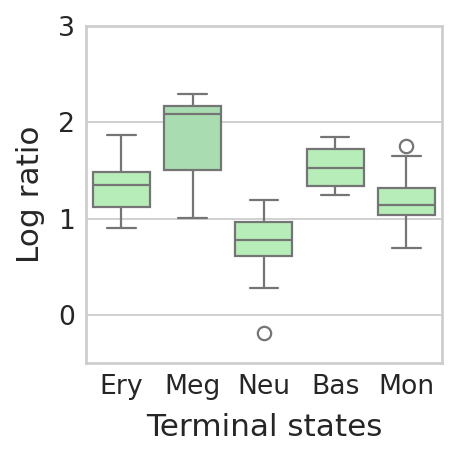

In [13]:
scores = {
    "Ery": np.log10(vi_score[terminal_state == "Ery"] / regvi_score[terminal_state == "Ery"]),
    "Meg": np.log10(vi_score[terminal_state == "Meg"] / regvi_score[terminal_state == "Meg"]),
    "Neu": np.log10(vi_score[terminal_state == "Neu"] / regvi_score[terminal_state == "Neu"]),
    "Bas": np.log10(vi_score[terminal_state == "Bas"] / regvi_score[terminal_state == "Bas"]),
    "Mon": np.log10(vi_score[terminal_state == "Mon"] / regvi_score[terminal_state == "Mon"]),
}

# Combine into a DataFrame
df = pd.DataFrame(scores)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(figsize=(3, 3))

    # Step 4: Color based on significance

    sns.boxplot(data=df, palette=palette)

    # Add titles and labels
    plt.ylim(-0.5, 3)
    plt.xlabel("Terminal states")
    plt.ylabel("Log ratio")

    fig.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "terminal_states_noise_ratio.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    plt.show()